In [1]:
from lxml import etree
from lxml.etree import tostring, parse
import wikitextparser as wtp
import pandas as pd
import re
import networkx as nx
import mwparserfromhell 
from annoy import AnnoyIndex
from sentence_transformers import SentenceTransformer, util
import torch
import os
import matplotlib.pyplot as plt
from functools import reduce
import bz2
import subprocess
import xml.sax
import numpy as np

### Un fichier *requirements* recense les librairies à installer.

In [65]:
req = open("requirements.txt", "r")
for lib in req:
    try:
        import lib
    except:
        pip.main(['install', lib])

In [2]:
from functions import WikiXmlHandler, cleanhtml, store_data, load_corpus, import_enc, produce_prediction

# Graph et similarité entre les textes (sur un portion d'un dump Wikipédia)

In [3]:
data_path = 'enwiki-20201001-pages-articles1.xml-p1p41242.bz2'

In [6]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)
i = 0
old = 0
for line in bz2.BZ2File(data_path, 'r'):
    parser.feed(line)
    if i == 0:
        old = len(handler._pages)
        i+=1
    else:
        if old != len(handler._pages):
            i+=1
            if i%5000 == 0:
                print("{} articles have been processed".format(i))
        old = len(handler._pages)

5000 articles have been processed
10000 articles have been processed
15000 articles have been processed
20000 articles have been processed


## Node links - Graph

In [28]:
article_name = []
text_article = []
wikil = [] # Cette liste contient tous les wikilinks/liens internes

for p in handler._pages:
    chosen_page = p

    article_name.append(chosen_page[0])

    text_article.append(chosen_page[1])
    
    wikil.append(chosen_page[2])

In [104]:
for k in range(len(wikil)):
    wikil[k] = list(map(str, wikil[k]))

In [105]:
dict_articles = {"Name_article" : article_name, "Text_article" : text_article, "Links" : wikil}
links_nodes = pd.DataFrame(data = dict_articles) 

In [106]:
links_nodes.head()

,Name_article,Text_article,Links
0,AccessibleComputing,REDIRECT Computer accessibility,[Computer accessibility]
1,AfghanistanHistory,REDIRECT History of Afghanistan,[History of Afghanistan]
2,AfghanistanGeography,REDIRECT Geography of Afghanistan,[Geography of Afghanistan]
3,AfghanistanPeople,REDIRECT Demographics of Afghanistan,[Demographics of Afghanistan]
4,AfghanistanCommunications,REDIRECT Communications in Afghanistan,[Communications in Afghanistan]


In [108]:
links_nodes.to_pickle("links_nodes.pkl")

### Création d'un graph pour un article donné

J'avais stocké les wikilinks sous forme de liste de liens pour un article donné. Si j'avais directement attribué une ligne pour un couple article-lien, j'atteindrais plus de 2 millions de lignes pour seulement 1 tiers du dump. Cette solution n'était pas envisageable, d'où le split que je réalise seulement pour la création des graphes (avec la fonction *explode* de pandas).

In [3]:
links_nodes = pd.read_pickle("links_nodes.pkl")

In [4]:
samp = links_nodes[-5:][["Name_article","Links"]].explode("Links")

In [5]:
samp.head()

,Name_article,Links
23603,Heterodyne repeater,Amateur radio repeater
23604,Heuristic routing,network topology
23604,Heuristic routing,Heuristic
23604,Heuristic routing,Routing
23604,Heuristic routing,telecommunications network


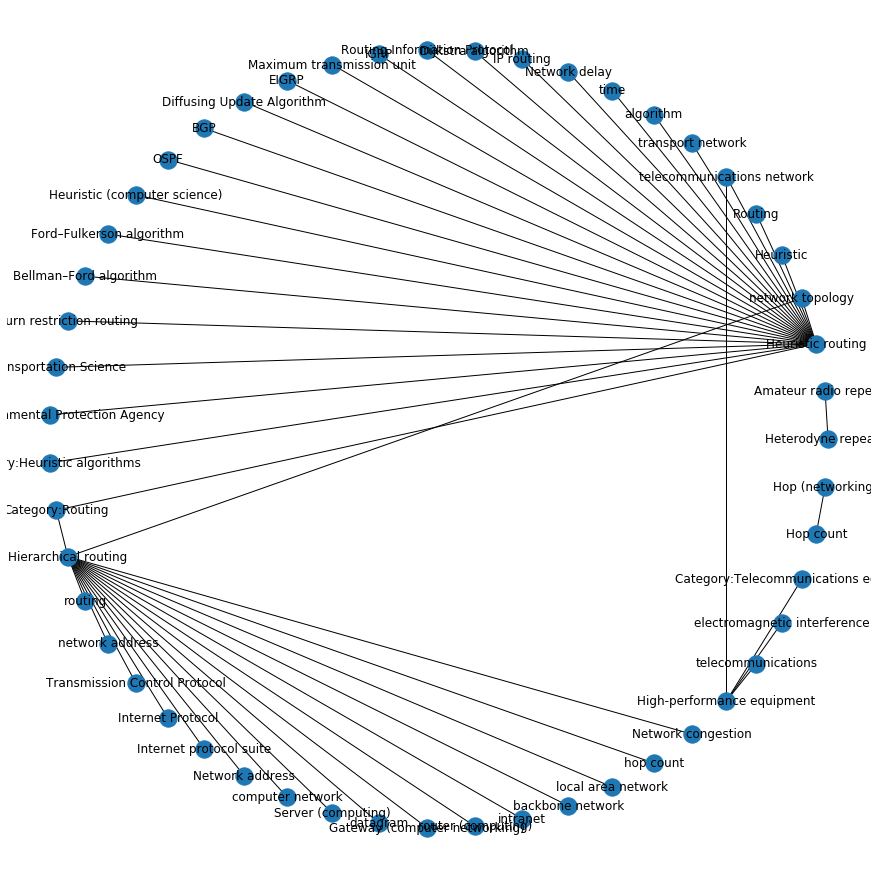

In [7]:
g = nx.from_pandas_edgelist(samp, source='Name_article', target='Links') 
pos = nx.circular_layout(g)

plt.figure(3,figsize=(12,12)) 
nx.draw(g,pos, with_labels = True)

plt.savefig("exemple_graph_articles.png")
plt.show()

## Text Similarity

Je vais utiliser le premier paragraphe pour calculer la similarité entre les documents. Autrement, j'aurais beaucoup trop de caractères spéciaux qui, malgré le preprocessing effectuées auparavant, n'ont pas tous été supprimés.

In [8]:
text_articles = pd.read_pickle("links_nodes.pkl")

In [9]:
text_articles.tail()

,Name_article,Text_article,Links
23603,Heterodyne repeater,REDIRECT Amateur radio repeater,[Amateur radio repeater]
23604,Heuristic routing,Heuristic routing is a system used to describe...,"[network topology, Heuristic, Routing, telecom..."
23605,Hierarchical routing,Hierarchical routing is a method of routing i...,"[routing, network address, Transmission Contro..."
23606,High-performance equipment,High-performance equipment describes telecommu...,"[telecommunications, electromagnetic interfere..."
23607,Hop count,REDIRECTHop (networking),[Hop (networking)]


In [10]:
store_data(text_articles)

Done


In [11]:
model, embeddings = import_enc()

In [13]:
pred = produce_prediction("The Annapolis Valley is a valley and region in the Canadian province of Nova Scotia. It is located in the western part of the Nova Scotia peninsula, formed by a trough between two parallel mountain ranges along the shore of the Bay of Fundy. Statistics Canada defines the Annapolis Valley as an economic region, composed of Annapolis County, Kings County, and Hants County. ", model, embeddings)

pred_df = reduce(pd.DataFrame.append, map(lambda i: text_articles.loc[[i]], pred[0]))
pred_df

,Name_article,Text_article,Links
999,Annapolis Valley,The Annapolis Valley is a valley and region in...,"[List of regions of Canada, Statistics Canada,..."
11677,Nova Scotia,Nova Scotia () is a province in eastern Canada...,"[Provinces and territories of Canada, Constitu..."
7030,"Granville, New South Wales","Granville is a suburb in western Sydney, in th...","[Cumberland City Council, City of Parramatta, ..."


PROBLEME : beaucoup de redirections n'apparaissent pas dans notre dataset. Nous allons donc devoir généraliser l'étude au dump de la totalité de Wikipédia.


 
 

## Cas particulier : les articles de redirection

Comme nous pouvons le voir dans le tableau ci-dessous, de nombreux articles n'ont pour texte qu'une redirection vers un autre article. Nous devons donc prendre en charge ce cas d'usage pour attribuer le bon texte à un article donné. Sachant qu'une redirection peut mener à une autre redirection, il faudra utiliser une logique itérative afin de continuer à chercher le texte jusqu'à ce que l'on ne rencontre plus de redirection.


In [15]:
text_articles = pd.read_pickle("links_nodes.pkl")

In [45]:
links_nodes[links_nodes["Text_article"].str.contains("REDIRECT", na=False)].shape

(5856, 3)

Il y a donc 5856 articles qui pointent vers un autre article. Il est donc important de lier ces articles afin d'avoir un contenu textuel riche pour un article donné. Ce point est très important compte tenu du fait que j'utilise un modèle de NLP pour calculer la similarité entre les articles.

Je définie une fonction pour récupérer le contenu d'un article redirigeant vers un autre article

In [49]:
def redir_handler(data):
    for i,row in data.iterrows():
        
        if "REDIRECT" in row["Text_article"]:
            
            if "REDIRECT " in row["Text_article"]: # Cas où il y aurait un espace après REDIRECT
                target = row["Text_article"].replace("REDIRECT ","")

            else:
                target = row["Text_article"].replace("REDIRECT ","")

            while True:
                
                if target in data["Name_article"]:
                    
                    if "REDIRECT" not in row[row["Name_article"] == target]["Text_article"]:
                        row["Text_article"] = target
                    
                    else:
                        
                        if "REDIRECT " in row["Text_article"]:
                            target = row[row["Text_article"] == target]["Text_article"].replace("REDIRECT", "")
                        
                        else:
                            target = row[row["Text_article"] == target]["Text_article"].replace("REDIRECT ", "")
                        
                else:
                    break
            
    return data
                

In [54]:
redir_handler(links_nodes[:100])

,Name_article,Text_article,Links
0,AccessibleComputing,REDIRECT Computer accessibility,[Computer accessibility]
1,AfghanistanHistory,REDIRECT History of Afghanistan,[History of Afghanistan]
2,AfghanistanGeography,REDIRECT Geography of Afghanistan,[Geography of Afghanistan]
3,AfghanistanPeople,REDIRECT Demographics of Afghanistan,[Demographics of Afghanistan]
4,AfghanistanCommunications,REDIRECT Communications in Afghanistan,[Communications in Afghanistan]
...,...,...,...
95,Arithmetic mean,"In mathematics and statistics, the arithmetic ...","[mathematics, statistics, mean, W. H. Freeman,..."
96,American Football Conference,The American Football Conference (AFC) is one ...,"[National Football League, American Football L..."
97,Albert Gore,redirect Al Gore,[Al Gore]
98,AnEnquiryConcerningHumanUnderstanding,REDIRECT An Enquiry Concerning Human Understan...,[An Enquiry Concerning Human Understanding]


Il est clair qu'il n'y a pas assez d'articles pour pouvoir gérer les redirections.

Je vais donc devoir appliquer toutes mes fonctions au dump entier. Ces opérations seront très longues et coûteuses en termes de mémoire mais nécessaires afin d'obtenir des résultats probants. Le résultat sera également utile afin de calculer les shortest paths ou chemins les plus courts entre un article et un autre. 
Dans l'état actuel de la base de données, il n'est pas intéressant de s'y intéresser car la plupart des chemins sont "unitaires" (un article à un autre, sans prolongation du chemin vers un autre article).